In [ ]:
import os
import tarfile
import requests
import subprocess

# URLs del dataset
LIBRISPEECH_URL = "http://www.openslr.org/resources/12/test-clean.tar.gz"
LIBRISPEECH_TAR = "test-clean.tar.gz"
EXTRACTION_DIR = "LibriSpeech"

In [ ]:
# Función para descargar el dataset
def download_dataset(url, tar_name):
    """
    Descarga un archivo desde una URL y lo guarda con el nombre especificado.
    """
    if not os.path.exists(tar_name):
        print(f"Descargando {tar_name} desde {url}...")
        response = requests.get(url, stream=True)
        with open(tar_name, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Descarga completada: {tar_name}")
    else:
        print(f"El archivo {tar_name} ya existe. Omitiendo la descarga.")

# Función para extraer el dataset
def extract_dataset(tar_name, extraction_dir):
    """
    Extrae un archivo .tar.gz a un directorio específico.
    """
    if not os.path.exists(extraction_dir):
        print(f"Extrayendo {tar_name} a {extraction_dir}...")
        with tarfile.open(tar_name, "r:gz") as tar:
            tar.extractall(path=extraction_dir)
        print(f"Extracción completada: {extraction_dir}")
    else:
        print(f"El directorio {extraction_dir} ya existe. Omitiendo la extracción.")

# Función para convertir archivos FLAC a WAV
def convert_flac_to_wav(input_dir, output_dir):
    """
    Convierte archivos .flac a .wav en un directorio de salida.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print("Convirtiendo archivos FLAC a WAV...")
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".flac"):
                flac_path = os.path.join(root, file)
                wav_path = os.path.join(output_dir, file.replace(".flac", ".wav"))
                if not os.path.exists(wav_path):  # Evitar reconvertir
                    subprocess.run(["ffmpeg", "-i", flac_path, "-ar", "16000", "-ac", "1", wav_path], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("Conversión completada.")

# Función para crear un DataFrame con las transcripciones y rutas a los archivos WAV
def create_transcription_dataframe(librispeech_dir, wav_dir):
    """
    Crea un DataFrame con las transcripciones y las rutas de los archivos WAV.
    """
    transcriptions = []
    for root, _, files in os.walk(librispeech_dir):
        for file in files:
            if file.endswith(".txt"):  # Buscar archivos de transcripciones
                with open(os.path.join(root, file), "r") as f:
                    for line in f:
                        parts = line.strip().split(" ", 1)
                        audio_id = parts[0]
                        transcription = parts[1]
                        wav_path = os.path.join(wav_dir, f"{audio_id}.wav")
                        if os.path.exists(wav_path):  # Verificar que el archivo WAV existe
                            transcriptions.append({"wav_path": wav_path, "transcription": transcription})
                        else:
                            print(f"Archivo WAV no encontrado: {wav_path}")
    return pd.DataFrame(transcriptions)

In [ ]:
# Ejecutar la descarga, extracción y conversión
download_dataset(LIBRISPEECH_URL, LIBRISPEECH_TAR)
extract_dataset(LIBRISPEECH_TAR, EXTRACTION_DIR)
convert_flac_to_wav(os.path.join(EXTRACTION_DIR, "test-clean"), "wav_files")

El archivo test-clean.tar.gz ya existe. Omitiendo la descarga.
El directorio LibriSpeech ya existe. Omitiendo la extracción.
Convirtiendo archivos FLAC a WAV...
Conversión completada.


In [ ]:
import pandas as pd

In [ ]:
# Rutas de los directorios
EXTRACTION_DIR = "LibriSpeech/LibriSpeech"
TEST_CLEAN_DIR = os.path.join(EXTRACTION_DIR, "test-clean")
WAV_DIR = "wav_files"

# Paso 1: Descargar el dataset
download_dataset(LIBRISPEECH_URL, LIBRISPEECH_TAR)

# Paso 2: Extraer el dataset
extract_dataset(LIBRISPEECH_TAR, EXTRACTION_DIR)

# Paso 3: Convertir FLAC a WAV
convert_flac_to_wav(TEST_CLEAN_DIR, WAV_DIR)

# Paso 4: Crear el DataFrame con las transcripciones
transcriptions_df = create_transcription_dataframe(TEST_CLEAN_DIR, WAV_DIR)
print(f"Total de audios procesados: {len(transcriptions_df)}")

# Paso 5: Guardar el DataFrame en un archivo CSV (opcional)
output_csv = "transcriptions_test_clean.csv"
transcriptions_df.to_csv(output_csv, index=False)
print(f"Transcripciones guardadas en: {output_csv}")

# Paso 6: Mostrar las primeras filas del DataFrame (verificación)
print("\nPrimeras filas del DataFrame:")
print(transcriptions_df.head(10))

El archivo test-clean.tar.gz ya existe. Omitiendo la descarga.
El directorio LibriSpeech/LibriSpeech ya existe. Omitiendo la extracción.
Convirtiendo archivos FLAC a WAV...
Conversión completada.
Total de audios procesados: 2620
Transcripciones guardadas en: transcriptions_test_clean.csv

Primeras filas del DataFrame:
                        wav_path  \
0  wav_files/6930-75918-0000.wav   
1  wav_files/6930-75918-0001.wav   
2  wav_files/6930-75918-0002.wav   
3  wav_files/6930-75918-0003.wav   
4  wav_files/6930-75918-0004.wav   
5  wav_files/6930-75918-0005.wav   
6  wav_files/6930-75918-0006.wav   
7  wav_files/6930-75918-0007.wav   
8  wav_files/6930-75918-0008.wav   
9  wav_files/6930-75918-0009.wav   

                                       transcription  
0     CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS  
1  THE ENGLISH FORWARDED TO THE FRENCH BASKETS OF...  
2  CONGRATULATIONS WERE POURED IN UPON THE PRINCE...  
3  FROM THE RESPECT PAID HER ON ALL SIDES SHE SEE...  
4  SHE T

In [ ]:
!pip install jiwer

In [ ]:
!pip install torch torchaudio librosa transformers speechbrain nemo_toolkit matplotlib
#!pip install nemo_toolkit[all]
!pip install transformers speechbrain
!pip install nemo_toolkit[asr]

In [ ]:
import os
import pandas as pd
import librosa
import torch
from jiwer import wer
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    HubertForCTC,
    WhisperProcessor,
    WhisperForConditionalGeneration,
)
from nemo.collections.asr.models import ASRModel
from speechbrain.pretrained import EncoderDecoderASR
import time
import matplotlib.pyplot as plt

# Cargar modelos: cada uno como función separada
def load_nemo_model(model_name, nemo_path):
    """
    Cargar modelos NVIDIA NeMo
    """
    try:
        model = ASRModel.from_pretrained(nemo_path)
        print(f"Modelo {model_name} cargado correctamente.")
        return model
    except Exception as e:
        print(f"Error cargando modelo {model_name}: {e}")
        return None


def load_huggingface_model(model_name, processor_path, model_path, whisper=False):
    """
    Cargar modelos de Hugging Face
    """
    try:
        processor = WhisperProcessor.from_pretrained(processor_path) if whisper else Wav2Vec2Processor.from_pretrained(processor_path)
        model = (
            WhisperForConditionalGeneration.from_pretrained(model_path)
            if whisper
            else Wav2Vec2ForCTC.from_pretrained(model_path)
        )
        print(f"Modelo {model_name} cargado correctamente.")
        return {"processor": processor, "model": model}
    except Exception as e:
        print(f"Error cargando modelo {model_name}: {e}")
        return None


def load_speechbrain_model(model_name, model_path):
    """
    Cargar modelos de SpeechBrain
    """
    try:
        model = EncoderDecoderASR.from_hparams(source=model_path, savedir=f"pretrained_models/{model_name}")
        print(f"Modelo {model_name} cargado correctamente.")
        return model
    except Exception as e:
        print(f"Error cargando modelo {model_name}: {e}")
        return None

In [ ]:
# Cargar todos los modelos
def load_models():
    models = {
        "Jasper": {
            "framework": "NVIDIA NeMo",
            "model": load_nemo_model("Jasper", "stt_en_jasper10x5dr"),
        },
        "QuartzNet": {
            "framework": "NVIDIA NeMo",
            "model": load_nemo_model("QuartzNet", "stt_en_quartznet15x5"),
        },
        "Conformer": {
            "framework": "NVIDIA NeMo",
            "model": load_nemo_model("Conformer", "stt_en_conformer_ctc_large"),
        },
        "Wav2Vec2.0": {
            "framework": "Hugging Face",
            "hf": load_huggingface_model(
                "Wav2Vec2.0", "facebook/wav2vec2-large-960h", "facebook/wav2vec2-large-960h"
            ),
        },

        "SpeechBrain": {
            "framework": "SpeechBrain",
            "model": load_speechbrain_model(
                "SpeechBrain", "speechbrain/asr-transformer-transformerlm-librispeech"
            ),
        }
    }
    return models

In [ ]:
# Función para evaluar un modelo en un archivo de audio
def evaluate_model(model_name, config, audio_path, expected_transcription):
    """
    Evaluar un modelo en un archivo de audio y calcular WER.
    """
    try:
        # Cargar audio
        audio, sr = librosa.load(audio_path, sr=16000)

        # Procesar según el framework
        start_time = time.time()
        if config["framework"] == "NVIDIA NeMo":
            transcription = config["model"].transcribe([audio_path])[0]
        elif config["framework"] == "Hugging Face":
            inputs = config["hf"]["processor"](audio, sampling_rate=16000, return_tensors="pt", padding=True)
            if model_name == "Whisper":
                generated_ids = config["hf"]["model"].generate(inputs.input_features)
                transcription = config["hf"]["processor"].batch_decode(
                    generated_ids, skip_special_tokens=True
                )[0]
            else:
                logits = config["hf"]["model"](inputs.input_values).logits
                predicted_ids = torch.argmax(logits, dim=-1)
                transcription = config["hf"]["processor"].batch_decode(predicted_ids)[0]
        elif config["framework"] == "SpeechBrain":
            transcription = config["model"].transcribe_file(audio_path)

        # Calcular tiempo de inferencia y WER
        inference_time = time.time() - start_time
        error_rate = wer(expected_transcription.lower(), transcription.lower())

        return transcription, error_rate, inference_time

    except Exception as e:
        print(f"Error evaluando el modelo {model_name}: {e}")
        return None, None, None


# Evaluar todos los modelos
def evaluate_all_models(models, transcriptions_df):
    results = []
    for _, row in transcriptions_df.iterrows():
        audio_path = row["wav_path"]
        expected_transcription = row["transcription"]

        print(f"\nEvaluando archivo: {audio_path}")
        for model_name, config in models.items():
            print(f"  -> Modelo: {model_name}")
            transcription, error_rate, inference_time = evaluate_model(
                model_name, config, audio_path, expected_transcription
            )
            if transcription is not None:
                results.append(
                    {
                        "audio_file": audio_path,
                        "model": model_name,
                        "expected_transcription": expected_transcription,
                        "generated_transcription": transcription,
                        "wer": error_rate,
                        "inference_time": inference_time,
                    }
                )
    return pd.DataFrame(results)


In [ ]:
# Cargar modelos
models = load_models()

[NeMo I 2024-12-22 22:14:03 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_2.0.0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo.
[NeMo I 2024-12-22 22:14:03 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.0.0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo
[NeMo I 2024-12-22 22:14:03 common:826] Instantiating model from pre-trained checkpoint


[NeMo W 2024-12-22 22:14:40 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    
[NeMo W 2024-12-22 22:14:40 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /data2/vo

[NeMo I 2024-12-22 22:14:40 features:305] PADDING: 16


[NeMo W 2024-12-22 22:14:55 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/core/connectors/save_restore_connector.py:682: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

[NeMo I 2024-12-22 22:15:01 save_restore_connector:275] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0/stt_en_jasper10x5dr/856ae08d5c4bd78b5e27f696e96f7aab/stt_en_jasper10x5dr.nemo.
Modelo Jasper cargado correctamente.
[NeMo I 2024-12-22 22:15:01 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_2.0.0/stt_en_quartznet15x5/16661021d16e679bdfd97a2a03944c49/stt_en_quartznet15x5.nemo.
[NeMo I 2024-12-22 22:15:01 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.0.0/stt_en_quartznet15x5/16661021d16e679bdfd97a2a03944c49/stt_en_quartznet15x5.nemo
[NeMo I 2024-12-22 22:15:01 common:826] Instantiating model from pre-trained checkpoint


[NeMo W 2024-12-22 22:15:03 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: /asr_set_1.2/train/train_{0..1023}.tar
    num_workers: 20
    
[NeMo W 2024-12-22 22:15:03 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
   

[NeMo I 2024-12-22 22:15:03 features:305] PADDING: 16
[NeMo I 2024-12-22 22:15:04 save_restore_connector:275] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0/stt_en_quartznet15x5/16661021d16e679bdfd97a2a03944c49/stt_en_quartznet15x5.nemo.
Modelo QuartzNet cargado correctamente.
[NeMo I 2024-12-22 22:15:04 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_2.0.0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo.
[NeMo I 2024-12-22 22:15:04 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.0.0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo
[NeMo I 2024-12-22 22:15:04 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-12-22 22:15:13 mixins:173] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2024-12-22 22:15:13 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket1/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket2/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket3/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket4/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket5/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket6/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket7/tarred_audio_manifest.json
    - - /data2/nemo_asr/nemo_asr_set_3.0/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 1
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: false
    trim_

[NeMo I 2024-12-22 22:15:13 features:305] PADDING: 0
[NeMo I 2024-12-22 22:15:15 save_restore_connector:275] Model EncDecCTCModelBPE was successfully restored from /root/.cache/torch/NeMo/NeMo_2.0.0/stt_en_conformer_ctc_large/afb212c5bcf904e326b5e5751e7c7465/stt_en_conformer_ctc_large.nemo.
Modelo Conformer cargado correctamente.


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo Wav2Vec2.0 cargado correctamente.


[NeMo W 2024-12-22 22:15:27 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/speechbrain/processing/features.py:1311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

Modelo SpeechBrain cargado correctamente.


In [ ]:
# Cargar transcripciones
transcriptions_df = pd.read_csv("transcriptions_test_clean.csv")

# Limitar a los primeros 5 audios
transcriptions_df = transcriptions_df.head(10)

# Evaluar los modelos
results_df = evaluate_all_models(models, transcriptions_df)

# Guardar resultados
results_df.to_csv("evaluation_results.csv", index=False)
print("\nResultados guardados en 'evaluation_results.csv'.")


Evaluando archivo: wav_files/6930-75918-0000.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Evaluando archivo: wav_files/6930-75918-0001.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:13<00:00, 13.15s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Evaluando archivo: wav_files/6930-75918-0002.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.00s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Evaluando archivo: wav_files/6930-75918-0003.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:23<00:00, 23.07s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Evaluando archivo: wav_files/6930-75918-0004.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Evaluando archivo: wav_files/6930-75918-0005.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:10<00:00, 10.33s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Evaluando archivo: wav_files/6930-75918-0006.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Evaluando archivo: wav_files/6930-75918-0007.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Evaluando archivo: wav_files/6930-75918-0008.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Evaluando archivo: wav_files/6930-75918-0009.wav
  -> Modelo: Jasper


Transcribing: 100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


  -> Modelo: QuartzNet


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


  -> Modelo: Conformer


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


  -> Modelo: Wav2Vec2.0
  -> Modelo: SpeechBrain

Resultados guardados en 'evaluation_results.csv'.


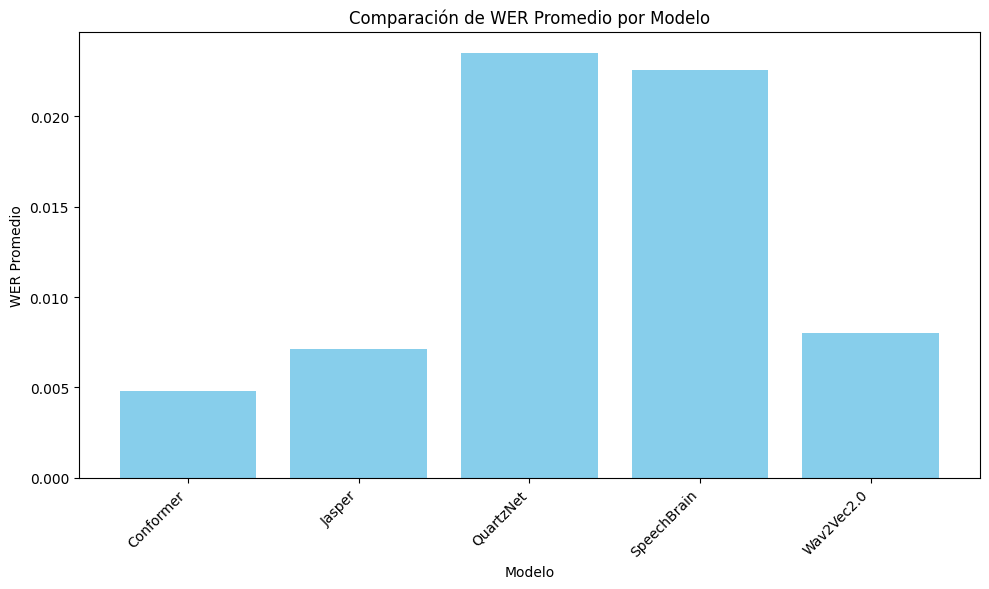

In [ ]:
# Gráfico para resultados
def plot_results(results_df):
    """
    Generar gráficos para WER promedio por modelo.
    """
    wer_per_model = results_df.groupby("model")["wer"].mean().reset_index()
    plt.figure(figsize=(10, 6))
    plt.bar(wer_per_model["model"], wer_per_model["wer"], color="skyblue")
    plt.xlabel("Modelo")
    plt.ylabel("WER Promedio")
    plt.title("Comparación de WER Promedio por Modelo")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Generar gráfico
plot_results(results_df)

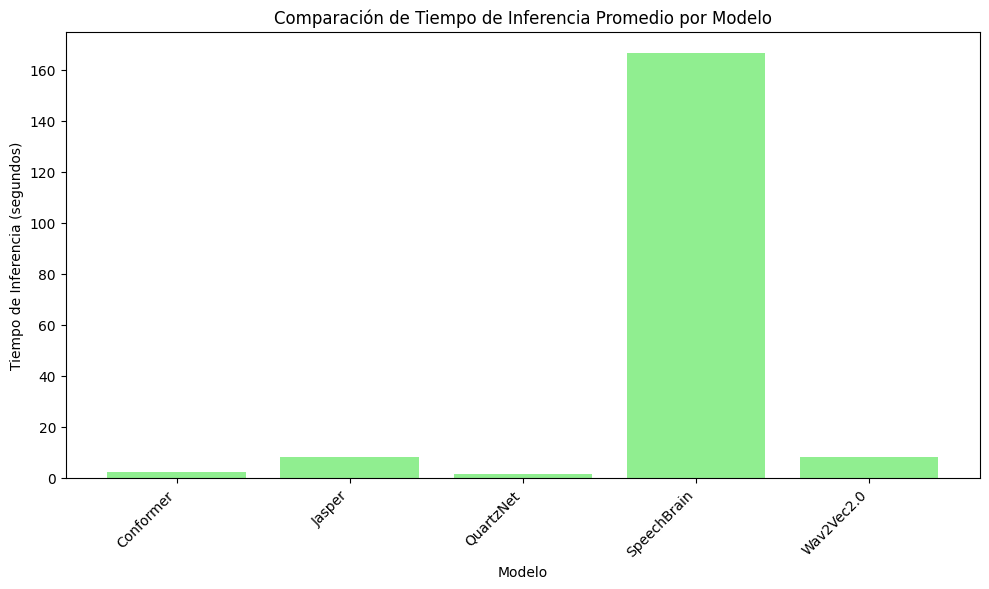

In [ ]:
# Gráfico de Tiempo de Inferencia Promedio por Modelo
def plot_inference_time(results_df):
    """
    Generar gráfico de tiempo de inferencia promedio por modelo.
    """
    inference_time_per_model = results_df.groupby("model")["inference_time"].mean().reset_index()
    plt.figure(figsize=(10, 6))
    plt.bar(inference_time_per_model["model"], inference_time_per_model["inference_time"], color="lightgreen")
    plt.xlabel("Modelo")
    plt.ylabel("Tiempo de Inferencia (segundos)")
    plt.title("Comparación de Tiempo de Inferencia Promedio por Modelo")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_inference_time(results_df)


In [ ]:
# Calcular promedios por modelo
average_metrics = results_df.groupby("model").agg(
    wer_avg=("wer", "mean"),
    inference_time_avg=("inference_time", "mean")
).reset_index()

# Mostrar resultados por pantalla
print("\nResultados Promedio por Modelo:")
print(average_metrics)



Resultados Promedio por Modelo:
         model   wer_avg  inference_time_avg
0    Conformer  0.004788            2.111002
1       Jasper  0.007114            8.103802
2    QuartzNet  0.023502            1.434753
3  SpeechBrain  0.022556          166.623010
4   Wav2Vec2.0  0.008014            8.316536
